# Word Embedding Playground

In [5]:
import spacy
import gensim.downloader as api
import gensim
import csv


import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE



We can mess with word embeddings. 

# Option 1: Our embeddings

We can use the embeddings that we trained! Or that we will train!

# Option 2: Pre-trained embeddings

Alternately, we can use pretrained vectors or embeddings downloaded from the internet. We can use Word2Vec, or GloVe, which is a model that came out a few years later and works very well. 

We use `gensim` which is a great library for working with embeddings and training topic models. It has some 

In [6]:
info = api.info()

Print out available models (i.e. embeddings)

In [7]:
for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'][:40] + '...',
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records): Pre-trai

The first time you load a new dataset it will take a while to download, and the files can be quite large.

In [58]:

# keep this commented out - I'm using this dataset 
model_news = api.load("glove-wiki-gigaword-100")

# You should use these embeddings, and compare your results with mine!
# model_wiki =  api.load("glove-wiki-gigaword-50")

[=========-----------------------------------------] 18.3% 23.4/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.1% 80.8/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 128.1/128.1MB downloaded


In [59]:
model = model_news

In [11]:
model['bathroom']

array([ 0.47039 ,  0.32983 , -0.11822 , -0.30487 ,  0.46672 ,  0.11681 ,
        0.21571 ,  0.21465 , -0.35746 , -0.22407 , -0.71762 , -0.076821,
       -0.096197,  0.74122 ,  0.5471  ,  0.67752 , -0.99857 ,  0.46604 ,
        0.58265 , -1.1309  ,  1.0421  ,  1.1271  , -0.72307 ,  0.24919 ,
       -0.13168 , -0.63536 , -0.075199,  1.1754  ,  1.1626  , -0.41526 ,
        1.3162  ,  0.19833 , -0.040513, -0.071552, -0.11446 ,  1.6381  ,
        1.0876  ,  0.43981 ,  1.4721  , -0.32986 ,  0.61208 ,  0.1837  ,
        0.06253 ,  1.3017  ,  0.44427 ,  0.15249 ,  0.40017 , -1.5666  ,
        0.83541 , -0.38038 ], dtype=float32)

## Option 3: Train Embeddings

You can also train embeddings from a saved corpus. 

 For our experiments, we're going to use the abstracts of all ArXiv papers in the category cs.CL (computation and language) that were published before mid-April 2021 — a total of around 25,000 documents. We tokenize these abstracts with spaCy.

We define a wrapper to deal with csv data with one column.

Each column contains an abstract of an NLP paper. 

If your csv looks different, you will have to change this function to get the right column. 

In [12]:
class Corpus(object):

    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")
        
    def __iter__(self):
        with open(self.filename, "r") as i:
            reader = csv.reader(i, delimiter=",")
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens
                            

In [13]:
documents = Corpus("../data/arxiv.csv")

In [14]:
arxiv_model = gensim.models.Word2Vec(documents, min_count=50, window=5, vector_size=100)
arxiv_model.save("word2vec.arxiv.model")

In [15]:
arxiv_model = arxiv_model.wv

When we train our word embeddings, gensim allows us to set a number of parameters. The most important of these are min_count, window, vector_size and sg

* `min_count` is the minimum frequency of the words in our corpus. For infrequent words, we just don't have enough information to train reliable word embeddings. It therefore makes sense to set this minimum frequency to at least 10. In these experiments, we'll set it to 100 to limit the size of our model even more.
* `window` is the number of words to the left and to the right that make up the context that word2vec will take into account.
* `vector_size` is the dimensionality of the word vectors. This is generally between 100 and 1000. This dimensionality often forces us to make a trade-off: embeddings with a higher dimensionality are able to model more information, but also need more data to train.
* `sg`: there are two algorithms to train word2vec: skip-gram and CBOW. Skip-gram tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. By default, Gensim uses CBOW (sg=0).


# Playing with Embeddings

Let's take a look at the trained model. The word embeddings are on its wv attribute, and we can access them by the using the token as key. For example, here is the embedding for nlp, with the requested 100 dimensions.

We can also easily find the similarity between two words. Similarity is measured as the cosine between the two word embeddings, and therefore ranges between -1 and +1. The higher the cosine, the more similar two words are. As expected, the figures below show that nmt (neural machine translation) is closer to smt (statistical machine translation) than to ner (named entity recognition).

In [16]:
model = model_news

In [23]:


print(model.similarity("capitalism", "evil"))
print(model.similarity("communism", "evil"))
print(model.similarity("anarchism", "evil"))
print(model.similarity("libertarianism", "evil"))


0.5491773
0.50700843
0.18693028
0.1712513




In a similar vein, we can find the words that are most similar to a target word. The words with the most similar embedding to bert are all semantically related to it: other types of pretrained models such as roberta, mbert, xlm, as well as the more general model type BERT represents (transformer and transformers), and more generally related words (pretrained)

In [32]:
model.similar_by_word("otter", topn=10)

[('smooth-coated', 0.7635948061943054),
 ('raccoon', 0.717721164226532),
 ('beaver', 0.7122237682342529),
 ('gull', 0.7109364867210388),
 ('mink', 0.6994276642799377),
 ('goose', 0.6876475811004639),
 ('pigeon', 0.6668442487716675),
 ('heiberg', 0.65448397397995),
 ('sofie', 0.6500213742256165),
 ('swan', 0.6461095809936523)]

Interestingly, we can look for words that are similar to a set of words and dissimilar to another set of words at the same time. This allows us to look for analogies of the type BERT is to a transformer like an LSTM is to .... Our embedding model correctly predicts that LSTMs are a type of RNN, just like BERT is a particular type of transformer.

    > solves
    > 3 : 1 :: 2 : _____
    > man : king :: woman : _______

In [34]:
model.most_similar(positive=["king", "woman"], negative=["man"], topn=10)

[('queen', 0.8523604273796082),
 ('throne', 0.7664334177970886),
 ('prince', 0.7592144012451172),
 ('daughter', 0.7473883628845215),
 ('elizabeth', 0.7460219860076904),
 ('princess', 0.7424570322036743),
 ('kingdom', 0.7337412238121033),
 ('monarch', 0.721449077129364),
 ('eldest', 0.7184861898422241),
 ('widow', 0.7099431157112122)]

In [60]:
model.most_similar(positive=["cake", 'pizza'], negative=["dessert"], topn=10)

[('bread', 0.658203125),
 ('sandwich', 0.6400274634361267),
 ('pie', 0.6160756349563599),
 ('cakes', 0.6046992540359497),
 ('cookie', 0.6032609939575195),
 ('hut', 0.5826258063316345),
 ('baked', 0.5723884701728821),
 ('dough', 0.5608364939689636),
 ('baking', 0.5595906376838684),
 ('butter', 0.5594030022621155)]

#### Exercise: solve the analogy with your vectors!
    
    > pasta : pizza :: poutine : _____

In [47]:
# work here
#
#


## Disambiguation



Similarly, we can also zoom in on one of the meanings of ambiguous words. For example, in NLP tree has a very specific meaning, which is obvious from its nearest neighbours constituency, parse, dependency and syntax.


In [61]:
model.most_similar(positive=["pizza", "poutine"], negative=["pasta"], topn=1)

[('napoletana', 0.5071167349815369)]

In [80]:
model.most_similar(positive=["player"], topn=10)

[('players', 0.83854079246521),
 ('play', 0.7879276871681213),
 ('playing', 0.7753530144691467),
 ('game', 0.7579816579818726),
 ('team', 0.7488577961921692),
 ('football', 0.7376238107681274),
 ('played', 0.7316332459449768),
 ('plays', 0.7003870606422424),
 ('professional', 0.6977413892745972),
 ('basketball', 0.6963555812835693)]



However, if we specify we're looking for words that are similar to tree, but dissimilar to forest, suddenly it gives a different, more domesticated image of a tree.


In [63]:
model.most_similar(positive=["tree"], negative=["forest"], topn=10)

[('twiggy', 0.5055817365646362),
 ('spool', 0.48513951897621155),
 ('frond', 0.4610969126224518),
 ('daisy', 0.4511006772518158),
 ('powerpc', 0.44649988412857056),
 ('screw', 0.4420185387134552),
 ('tulip', 0.43746548891067505),
 ('huggers', 0.42768552899360657),
 ('ornament', 0.4260554313659668),
 ('plucking', 0.4256293475627899)]



Finally, we can present the word2vec model with a list of words and ask it to identify the odd one out. It then uses the word embeddings to identify the word that is least similar to the other ones. For example, in the list lstm cnn gru svm transformer, it correctly identifies svm as the only non-neural model. In the list bert word2vec gpt-2 roberta xlnet, it correctly singles out word2vec as the only non-transormer model. In word2vec bert glove fasttext elmo, bert is singled out as the only transformer.


In [70]:
print(model.doesnt_match("effervescent bubbly sparkling drab".split()))
print(model.doesnt_match("monarchy democracy bureaucracy communism socialism".split()))
print(model.doesnt_match("bert ernie elmo barney".split()))
print(model.doesnt_match("saving turtle thrifty cautious".split()))

drab
bureaucracy
elmo
turtle


# Plotting Embeddings



Let's now visualize some of our embeddings. To plot embeddings with a dimensionality of 100 or more, we first need to map them to a dimensionality of 2. We do this with the popular t-SNE method. T-SNE, short for t-distributed Stochastic Neighbor Embedding, helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in the low-dimensional space.

T-SNE is present in Scikit-learn. To run it, we just have to specify the number of dimensions we'd like to map the data to (n_components), and the similarity metric that t-SNE should use to compute the similarity between two data points (metric). We're going to map to 2 dimensions and use the cosine as our similarity metric. Additionally, we use PCA as an initialization method to remove some noise and speed up computation. The Scikit-learn user guide contains some additional tips for optimizing performance.

Plotting all the embeddings in our vector space would result in a very crowded figure where the labels are hardly legible. Therefore we'll focus on a subset of embeddings by selecting the 200 most similar words to a target word.



In [73]:

# list of words to map
target_word = "disaster"
selected_words = [w[0] for w in model.most_similar(positive=[target_word], topn=100)] + [target_word]

# list of embeddings for our target words
embeddings = [model[w] for w in selected_words] + model["bert"]

# 2-D reduction of embeddings
mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)




If we take bert as our target word, the figure shows some interesting patterns. In the immediate vicinity of bert, we find the similar transformer models that we already identified as its nearest neighbours earlier: xlm, mbert, gpt-2, and so on. Other parts of the picture have equally informative clusters of NLP tasks and benchmarks (squad and glue), languages (german and english), neural-network architectures (lstm, gru, etc.), embedding types (word2vec, glove, fasttext, elmo), etc.


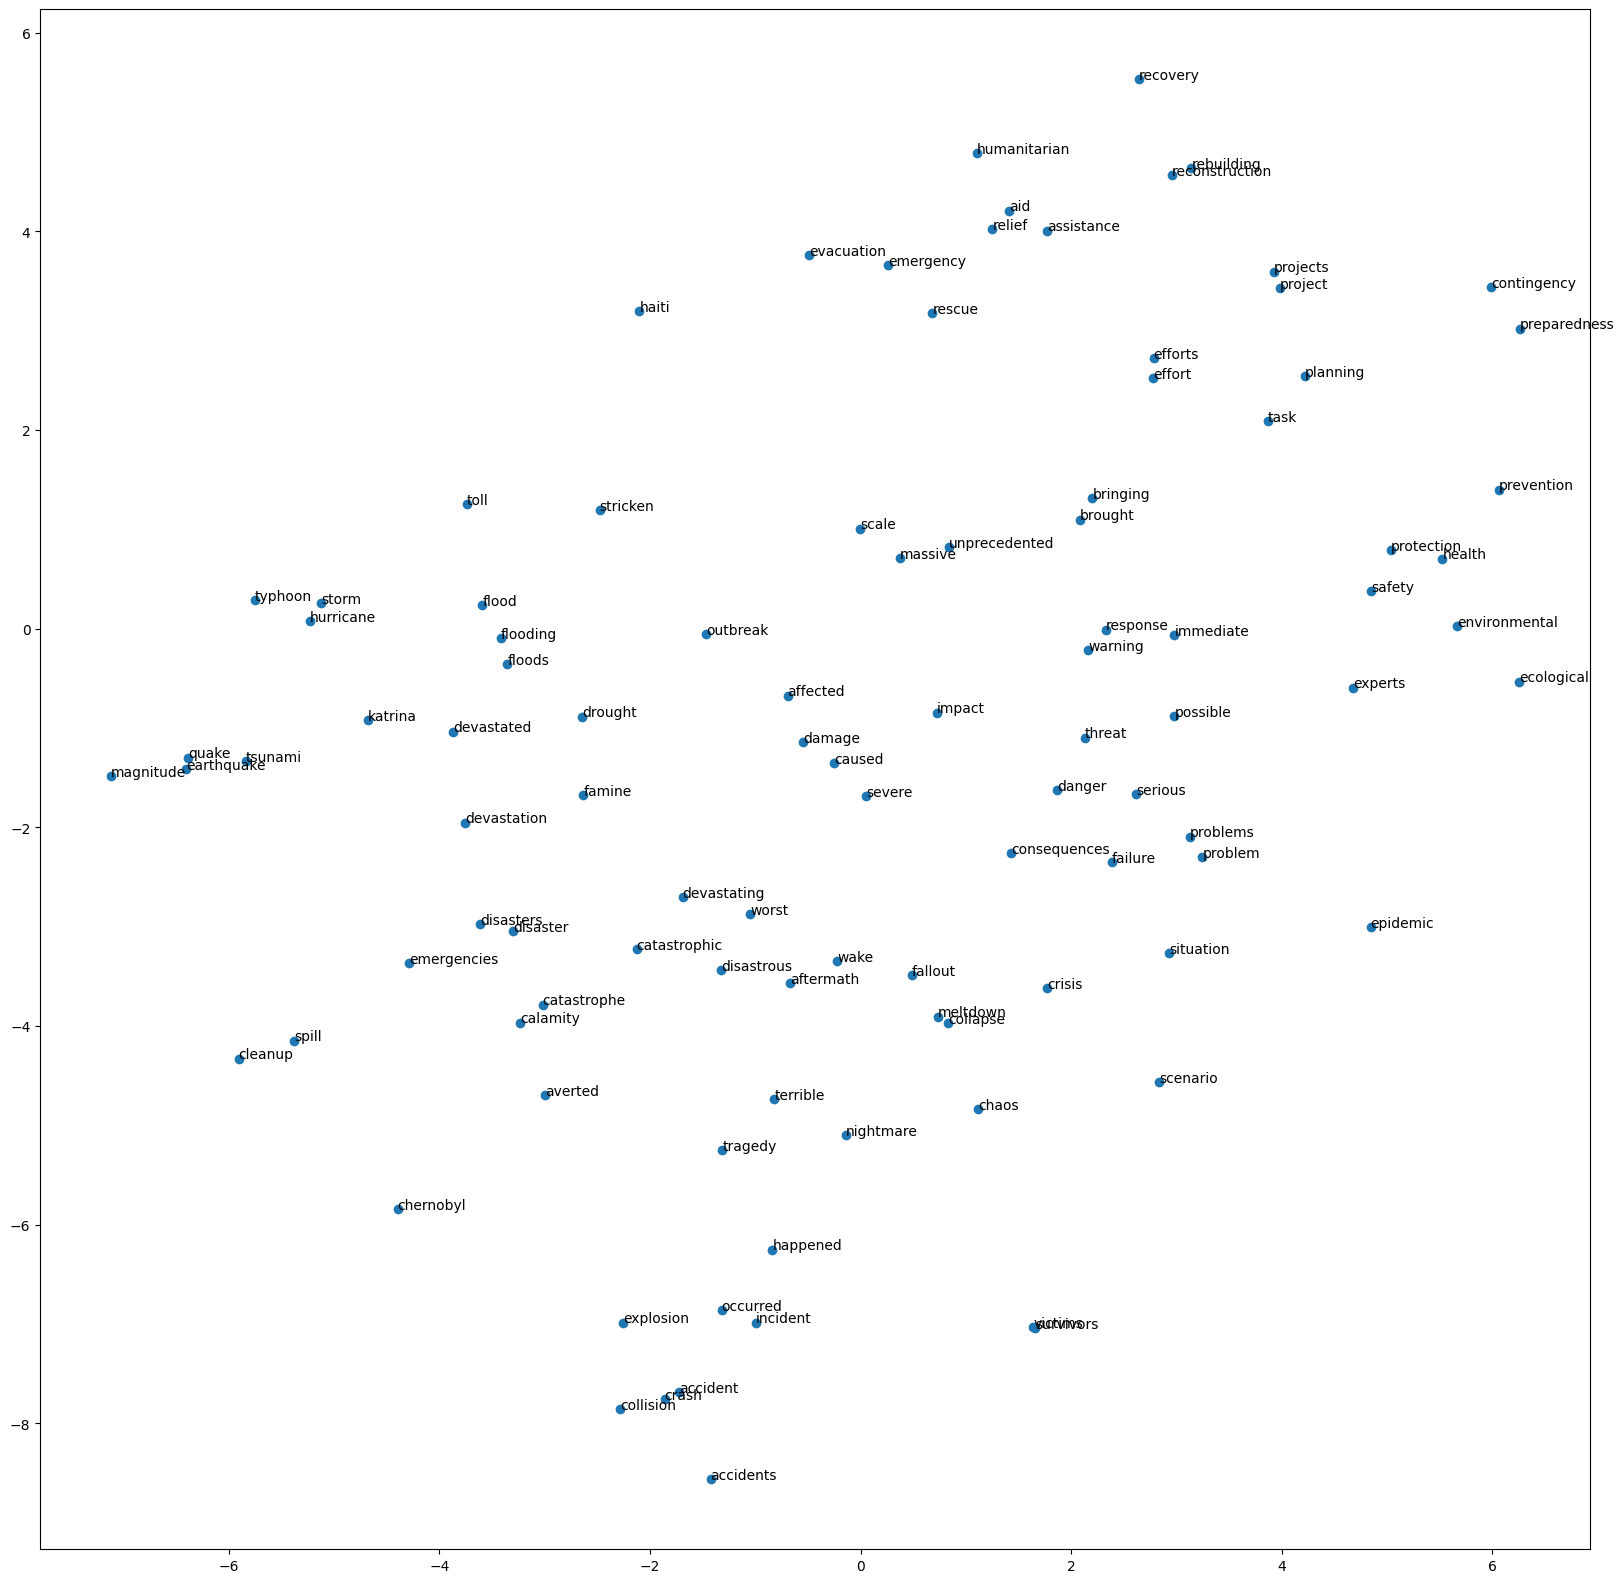

In [74]:
%matplotlib inline


plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)


# add labels to our map visualization
for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

# Compare to Twitter

Here are 50 dimension GloVe vectors from twitter. Use these for the exercises below.

In [75]:
# download the model and return as object ready for use
# embeddings_glove_twitter = api.load("glove-twitter-25")
model_glove_twitter = api.load("glove-twitter-100")



[===-----------------------------------------------] 6.1% 23.4/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 18.3% 71.0/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.2% 124.8/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.3% 167.6/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.7% 184.8/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.5% 234.4/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.6% 300.6/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.2% 360.6/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Exercise: Semantic Similarity


What is the semantic similarity between 'meaning' and 'interpretation' in twitter space?
What about meaning and extract?

How does this compare to the arxiv embeddings?

In [ ]:
# answer here
#
#
 
 

Pick two more concepts and compare their cosine similarity in two different vector space models

## Exercise: Near Neighbors

What are the nearest neighbors of these concepts?

In [ ]:
# answer here
#
#
#

## Exercise: Analogy

How does twitter solve the tree analogy?

In [ ]:
# answer here
#
#


Try another analogy. What is the result? In your mind, what shoudl the answer be?

In [ ]:
# answer here
#
#


# Exercise: Plot spatial relationships

Pick a set of words that are related to each other in the same way. For instance you could use countries and their capitals, or adjectives and their superlatives

e.g.

```
Rome - Italy

Beijing - China

Berlin - Germany

Ottowa - Canada
```

superlatives
``` 
bad - worse

good - better

warm - warmer

red - redder

blue - bluer
```

What do you notice?

In [ ]:
"""
Answer here

You'll need to copy the code for visualization from above 
but edit certain parts to give you the embeddings of the words 
you want to look at
""" 





"""
"""

#  Training new embeddings

## Load your own corpus

Or choose one of the corpora saved in `../data`

Load the corpus into memory (returns a Dataset object, which is the exact kind of object we need).

We define a wrapper to deal with csv data with one column.

Each column contains an abstract of an NLP paper. 

If your csv looks different, you will have to change this function to get the right column. 